# Handling Missing Data

1. Mean/ Mode
2. KNN with top 15 features
3. KNN with all the features

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sets import Set
from scipy.stats import norm
from scipy import spatial
from scipy.stats import mode
from sklearn.neighbors import KDTree
import sys
import time
from multiprocessing import Pool

color = sns.color_palette()
%matplotlib inline

sys.setrecursionlimit(1000000)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: the sets module is deprecated


Importing Data

In [2]:
df = pd.read_pickle("train_df_partial_filled.pkl")
n_rows,c_cols = df.shape


In [ ]:
# Missing features
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

print missing_df['column_name'].count()

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

# 1. Mean/ Mode

In [ ]:
missing_features = list(missing_df["column_name"].values)
print missing_features
print("\n")

for feature in missing_features:
    try:
        if df[feature].dtype == ('int64') or df[feature].dtype == ('float64'):
            df[feature] = df[feature].fillna(df[feature].mean())
            print ("Successfully filled %s" %feature)
        
    except:
        print("%s not filled" %feature)
        pass

In [ ]:
sns.distplot(df["yearbuilt"].values)

In [ ]:
df.isnull().sum(axis=0)

4 fields do not have numeric values and still have missing data.

1. hashottuborspa - over 98% missing -> filled with False
2. propertycountylandusecode - Filled with mode
3. propertyzoningdesc - over 1/3rd missing -> filled with mode
4. fireplaceflagvalue -  over 99% missing -> filled with False

For analysis, it might be better off to ignore these espcially 1,4

In [ ]:
# Filling the above columns
df["fireplaceflag"] = df["fireplaceflag"].fillna(False)
df["hashottuborspa"] = df["hashottuborspa"].fillna(False)
df["propertyzoningdesc"] = df["propertyzoningdesc"].fillna(df["propertyzoningdesc"].mode().values[0])
df["propertycountylandusecode"] = df["propertycountylandusecode"].fillna(df["propertycountylandusecode"].mode().values[0])

In [ ]:
# Save the dataframe
df.to_pickle("df_train_filled_with_mean_mode.pkl")

# 2. KNN with top 15 features


Import feature importance df to use 15 most important features.

In [99]:
df_f_imp = pd.read_pickle("feature_importance.pkl")

In [100]:
df_f_imp

,index,Not Missing %,SUM
0,structuretaxvaluedollarcnt,98.00,102
1,yearbuilt,98.00,100
2,propertylandusetypeid,100.00,83
3,lotsizesquarefeet,91.00,82
4,calculatedfinishedsquarefeet,98.00,80
5,taxamount,99.00,77
6,finishedsquarefeet12,91.00,72
7,regionidcity,100.00,64
8,landtaxvaluedollarcnt,98.00,63
9,latitude,100.00,53


## Using KDTree to find nearest neighbors

### Fill the first 15 

### Type 1: Each feature has its own tree based on features with 100% data 

### Vectorized form

In [146]:
class knn(object):
    
    def __init__(self,feature,tree):
        self.feature = feature
        self.tree = tree

    def mean(self,X,df,k):
        # f refers to feature
        dist,ind = self.tree.query(X,k=k)
        [m,n] = ind.shape
        f_value = lambda t: df[self.feature].iloc[t]
        map_f = np.vectorize(f_value)
        f_matrix = map_f(ind)
        feature_mean = np.nanmean(f_matrix,axis = 1)
        #feature_mean = np.mean(df[self.feature].iloc[ind[0]].as_matrix())

        return feature_mean



In [194]:
# create top 15 features dataframe in order of filled data (non missing data)
df_f_tmp2 = df_f_imp[0:15].sort_values(by="Not Missing %", ascending=False)
top_15_f = list(df_f_tmp2["index"].values) 
df_top_15 = df[top_15_f]

counter = 0

for feature in top_15_f:

        if df_f_tmp2["Not Missing %"][df_f_tmp2["index"]==feature].values[0] != 100.:
            
            print("Starting feature: %s" %feature)    
    
            # time the execution
            t1 = time.time()

            # create dataframe with features with 100% filled data
            # Everytime a feature is completed, the training data is updated
            full_f = list(df_f_imp["index"][df_f_imp["Not Missing %"]==100.].values) 
            df_full = df[full_f]

            # create training df and df_to_be_filled
            tmp_df1 = df_full.copy() 
            tmp_df1[feature] = df_top_15[feature]    # add feature column to df_full
            tmp_df2 = tmp_df1.dropna().reset_index()
            tmp_df3 = tmp_df2.drop([feature,"index"],1)
            df_to_be_filled = tmp_df1[tmp_df1[feature].isnull()] 
            [m,n]  = df_to_be_filled.shape
            training_df = tmp_df3.as_matrix()

            # start building tree
            t2 = time.time()
            print('Creating KDTree')
            tree = KDTree(training_df)
            # end tree
            t3 = time.time()
            print("Tree Build Time: %g" %(t3-t2))

            k = 50

            # fill the missing element
            X = df_to_be_filled[full_f].as_matrix()
            #X = np.reshape(X,(1,-1))
            f_knn = knn(feature,tree)
            df_to_be_filled[feature] = f_knn.mean(X,tmp_df2,k)

            # finish execution
            t4 = time.time()
            print("Exec time: %g" %(t4-t1))

            df_top_15.update(df_to_be_filled,join='left')
            df.update(df_to_be_filled,join='left')
            print("saving after completing %s" %feature)
            df_top_15.to_pickle("df.pkl")

            # update the feature importance dataframe
            if df_top_15[feature].isnull().sum() == 0:
                df_f_tmp2["Not Missing %"][df_f_tmp2["index"]==feature] = 100.
                df_f_imp["Not Missing %"][df_f_imp["index"]==feature] = 100.
            else:
                not_filled = df_top_15[feature].isnull().sum()
                print("Feature %s not completed. %g not filled" %(feature,not_filled))

            print("Finished feature %s" %feature)
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************")
            
        else:
            print("Already complete: %s " %feature)  
            
        counter += 1    

Already complete: propertylandusetypeid 
Already complete: regionidcity 
Already complete: latitude 
Already complete: longitude 
Already complete: rawcensustractandblock 
Starting feature: bedroomcnt
Creating KDTree
Tree Build Time: 15.367
Exec time: 16.93


C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


saving after completing bedroomcnt


C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finished feature bedroomcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: bathroomcnt
Creating KDTree
Tree Build Time: 15.573
Exec time: 17.172
saving after completing bathroomcnt
Finished feature bathroomcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: taxamount
Creating KDTree
Tree Build Time: 16.872
Exec time: 32.863
saving after completing taxamount
Finished feature taxamount
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: taxvaluedollarcnt
Creating KDTree
Tree Build Time: 17.433
Exec time: 41.81
saving after completing taxvaluedollarcnt
Finished feature taxvaluedollarcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: structuretaxvaluedollarcnt
Creating KDTree
Tree Build Time: 17.454
E

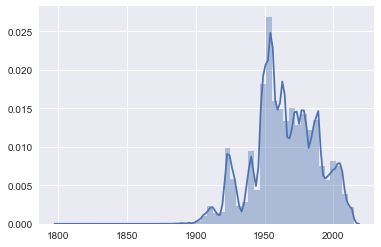

In [199]:
# Check the distribution of filled data
sns.distplot(df["yearbuilt"].values)

In [ ]:
# Load dataframe filled using mean-mode method
df_mean_style = pd.read_pickle("df_train_filled_with_mean_mode.pkl")

bathroomcnt


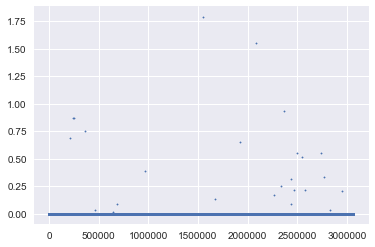

taxamount


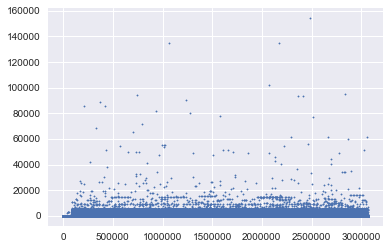

taxvaluedollarcnt


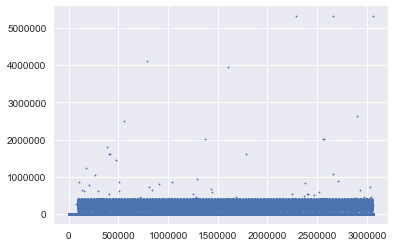

structuretaxvaluedollarcnt


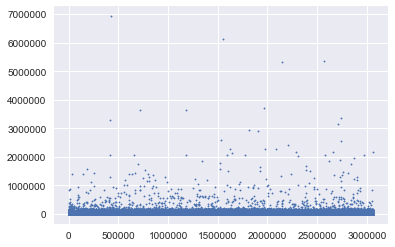

yearbuilt


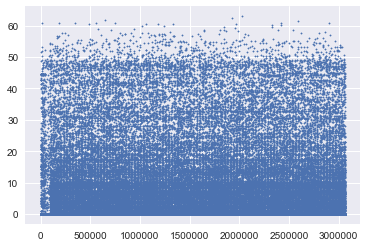

calculatedfinishedsquarefeet


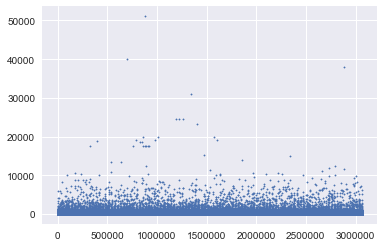

landtaxvaluedollarcnt


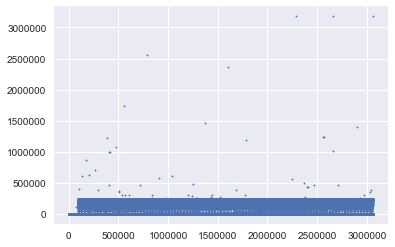

lotsizesquarefeet


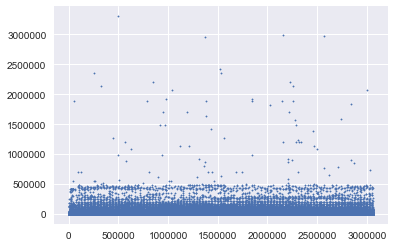

finishedsquarefeet12


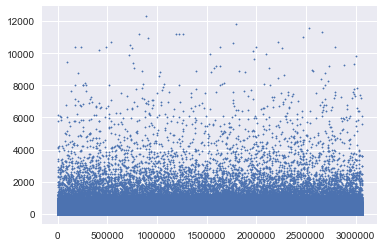

In [233]:
# compare the two methods
f_list = top_15_f[6:]

for f in f_list:
    print f
    x = df[f].values
    y = df_mean_style[f].values
    dev = np.absolute(x-y)
    num = np.linspace(0,len(dev),len(dev))
    plt.scatter(num,dev,s=2)
    #plt.hist([x, y],color=['r','b'], alpha=0.5)
    plt.show()
    

It is evident is from the above plots, the difference of managing data from both the methods is quite significant. Results should vary too

# Filling Rest of the data

### Rest of the data is filled using KNN with the features with 100% data (which includes the 15 filled above) 

In [3]:
na_perct = df.isnull().sum().values/(n_rows*1.0)
df_na_summary = pd.DataFrame(df.columns.tolist(),columns=["Feature"])
df_na_summary["% NA"] = na_perct
df_na_summary["feature_type"] = ["disc","cont","disc","factor","factor","cont","disc","disc","disc","disc",
                                "disc","factor","cont","cont","cont","cont","cont","cont","cont","cont",
                                "factor","disc","disc","cont","factor","factor","cont","cont","cont","disc",
                                "disc","factor","factor","factor","factor","factor","factor","disc","factor","factor",
                                "factor","factor","disc","factor","cont","factor","disc","cont","cont","disc",
                                "disc","factor","cont","cont","disc","cont","cont","factor","factor","disc"]

In [4]:
df_na_summary

,Feature,% NA,feature_type
0,parcelid,0.000000e+00,disc
1,logerror,0.000000e+00,cont
2,transactiondate,0.000000e+00,disc
3,airconditioningtypeid,7.257556e-01,factor
4,architecturalstyletypeid,9.979367e-01,factor
5,basementsqft,9.994546e-01,cont
6,bathroomcnt,8.159122e-06,disc
7,bedroomcnt,4.242744e-06,disc
8,buildingclasstypeid,9.958731e-01,disc
9,buildingqualitytypeid,3.486240e-01,disc


In [71]:
 p = Pool(16)

class knn_2(object):
    
    def __init__(self,feature,tree,df_na_summary):
        self.feature = feature
        self.tree = tree
        self.df_na_summary = df_na_summary

    def mean(self,X,df,k):
        # f refers to feature
       
        print("chkpt starting")
        dist,ind = self.tree.query(X,k=k)
        [m,n] = ind.shape
        f_value = lambda t: df[self.feature].iloc[t]
        print("chckpt 2")
        map_f = np.vectorize(f_value)
        print("vectorized")
        #f_matrix = map_f(ind)
        #results = p.map(f_value,((i, j) for i in range(m) for j in range(n)))
        #f_matrix = np.array(results).reshape(m,n)
        f_matrix = p.map(map_f,ind)
        print f_matrix.shape
        
        if self.df_na_summary["feature_type"][self.df_na_summary["Feature"]==self.feature].values[0] == 'cont':
            feature_m = np.nanmean(f_matrix,axis = 1)
     
        if self.df_na_summary["feature_type"][self.df_na_summary["Feature"]==self.feature].values[0] == 'disc':
            feature_m = np.nanmean(f_matrix,axis = 1)
            
        if self.df_na_summary["feature_type"][self.df_na_summary["Feature"]==self.feature].values[0] == 'factor':
            feature_m, feature_freq = mode(f_matrix,axis=1,nan_policy='omit')
            feature_m = np.ndarray.flatten(feature_m)
                    
        return feature_m


In [36]:
# create top 15 features dataframe in order of filled data (non missing data)
threshold = 0.9
to_be_filled = df_na_summary["Feature"][df_na_summary["% NA"] > threshold].values
full_features = df_na_summary["Feature"][df_na_summary["% NA"] == 0.0 ].values
to_remove = ["parcelid","logerror","transactiondate","taxdelinquencyflag"]
full_features = [x for x in full_features if x not in to_remove]
#full_features = np.asarray(full_features)

df_not_full_f = df[to_be_filled] # dataframe with features with incomplete data
df_full_features = df[full_features]
counter = 0

for feature in to_be_filled:
            
        print("Starting feature: %s" %feature)    

        # time the execution
        t1 = time.time()

        # create training df and df_to_be_filled
        tmp_df1 = df_full_features.copy() 
        tmp_df1[feature] = df_not_full_f[feature]    # add feature column to df_full
        tmp_df2 = tmp_df1.dropna().reset_index()
        tmp_df3 = tmp_df2.drop([feature,"index"],1)
        df_to_be_filled_2 = tmp_df1[tmp_df1[feature].isnull()] 
        [m,n]  = df_to_be_filled_2.shape
        training_df = tmp_df3.as_matrix()

        # start building tree
        t2 = time.time()
        print('Creating KDTree')
        tree = KDTree(training_df)
        # end tree
        t3 = time.time()
        print("Tree Build Time: %g" %(t3-t2))

        k = 50

        # fill the missing element
        X = df_to_be_filled_2[full_features].as_matrix()
        f_knn_2 = knn_2(feature,tree,df_na_summary)
        df_to_be_filled_2[feature] = f_knn_2.mean(X,tmp_df2,k)

        # finish execution
        t4 = time.time()
        print("Exec time: %g" %(t4-t1))

        df.update(df_to_be_filled_2,join='left')
        print("saving after completing %s" %feature)
        df_to_be_filled_2.to_pickle("df_filled_rest_of_the_features.pkl")

        print("Finished feature %s" %feature)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************")

        counter += 1  
        break
#df.to_pickle("df_filled_full.pkl")

Starting feature: architecturalstyletypeid
Creating KDTree
Tree Build Time: 0.00699997


KeyboardInterrupt: 

In [72]:
f_knn_2 = knn_2(feature,tree,df_na_summary)

In [93]:
p = Pool1(16)

def f_value(t):
    return df[feature].iloc[t]

def k_mean(X,df,k,feature,tree,df_na_summary):
    # f refers to feature

    print("chkpt starting")
    dist,ind = tree.query(X,k=k)
    [m,n] = ind.shape
    #f_value = lambda t: df[feature].iloc[t]
    print("chckpt 2")
    map_f = np.vectorize(f_value)
    print("vectorized")
    #f_matrix = map_f(ind)
    #results = p.map(f_value,((i, j) for i in range(m) for j in range(n)))
    #f_matrix = np.array(results).reshape(m,n)
    f_matrix = p.map(map_f,ind)
    print f_matrix.shape

    if df_na_summary["feature_type"][df_na_summary["Feature"]==feature].values[0] == 'cont':
        feature_m = np.nanmean(f_matrix,axis = 1)

    if df_na_summary["feature_type"][df_na_summary["Feature"]==feature].values[0] == 'disc':
        feature_m = np.nanmean(f_matrix,axis = 1)

    if df_na_summary["feature_type"][df_na_summary["Feature"]==feature].values[0] == 'factor':
        feature_m, feature_freq = mode(f_matrix,axis=1,nan_policy='omit')
        feature_m = np.ndarray.flatten(feature_m)

    return feature_m

In [101]:
dist,ind = tree.query(xx,k=k)
[m,n] = ind.shape
results = p.map(f_value,(ind[i, j] for i in range(m) for j in range(n)))
f_matrix = np.array(results).reshape(m,n)
print f_matrix.shape


PicklingError: Can't pickle <type 'function'>: attribute lookup __builtin__.function failed

In [ ]:
xx = X[0:100,:]
tq1 = time.time()
a =  k_mean(xx,tmp_df2,k,feature,tree,df_na_summary)
print time.time() - tq1